# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
#!!get_ipython().magic('matplotlib inline')
import matplotlib
%matplotlib inline
import os
import time
import cv2
import numpy as np
from numpy import float32
import tensorflow as tf
from datatools import *
from common import *
from traintools import *
from plottools import *
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import namedtuple
from tensorflow.contrib.learn.python.learn.datasets.mnist import dense_to_one_hot

print ("All imports successful")


All imports successful


In [30]:
# Load test and training data from input files
import pickle
training_file = 'data/train.p'
testing_file = 'data/test.p'
more_data_file = 'data/more_data.p'
checkpoint_file = 'checkpoints/ipnb_checkpoint.chk'
abort_file = 'abort'

FEATURES = 'features'
LABELS = 'labels'
SIZES = 'sizes'
COORDS = 'coords'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

x_train, y_train, sizes_train, coords_train = train[FEATURES], train[LABELS], train[SIZES], train[COORDS]
x_test, y_test, sizes_test, coords_test = test[FEATURES], test[LABELS], test[SIZES], test[COORDS]

print ("Test and trainign data loaded")

Test and trainign data loaded


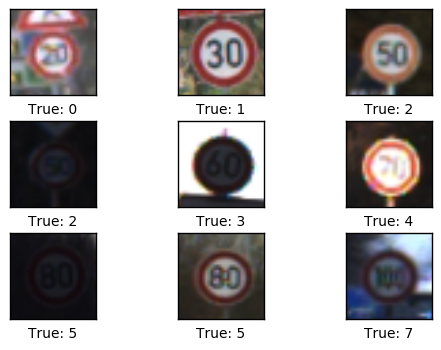

Here is the distribution of classes in the data:
Class	2:	2250 examples 	[% = 5.738478410569002]
Class	1:	2220 examples 	[% = 5.661965365094749]
Class	13:	2160 examples 	[% = 5.5089392741462415]
Class	12:	2100 examples 	[% = 5.355913183197735]
Class	38:	2070 examples 	[% = 5.279400137723482]
Class	10:	2010 examples 	[% = 5.126374046774975]
Class	4:	1980 examples 	[% = 5.049861001300722]
Class	5:	1860 examples 	[% = 4.743808819403708]
Class	25:	1500 examples 	[% = 3.825652273712668]
Class	9:	1470 examples 	[% = 3.749139228238415]
Class	7:	1440 examples 	[% = 3.6726261827641613]
Class	8:	1410 examples 	[% = 3.596113137289908]
Class	3:	1410 examples 	[% = 3.596113137289908]
Class	11:	1320 examples 	[% = 3.3665740008671476]
Class	35:	1200 examples 	[% = 3.0605218189701344]
Class	18:	1200 examples 	[% = 3.0605218189701344]
Class	17:	1110 examples 	[% = 2.8309826825473743]
Class	31:	780 examples 	[% = 1.9893391823305873]
Class	14:	780 examples 	[% = 1.9893391823305873]
Class	33:	689 examples

In [31]:
# Peek at the training images:
# The variations are along brightness/darkness, sharpness/blurriness,
#  perspective, surrounding noise, orientation and scaling.
ids = [0, 2150, 3134, 4523, 5745, 7534, 8324, 9103, 11524]
x_tmp = [train[FEATURES][i] for i in ids]
y_tmp = [train[LABELS][i] for i in ids]
plot_images(x_tmp, y_tmp, None)

#
# Distribution of classes: Determining the distribution of images
# by class is helpful so as to ensure that training data is not
# skewed in the direction of any individual class or set of classes.
# If one or more classes dominate over others, the model might just
# get trained to always return the label of the majority class, or
# might not train sufficiently on the other classes. Ie, the statistical
# distribution of classes in the training set plays a role in the
# precision of the resulting and recall of the resulting model.
#
# This method determines that distribution so that the data can be
# equalized (see next steps).
#
print ("Here is the distribution of classes in the data:")
print_distribution(train[FEATURES], train[LABELS])


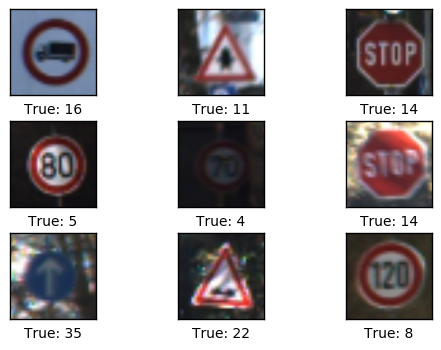

In [4]:
# Peek at the test images
# The variations are along brightness/darkness, sharpness/blurriness,
#  perspective, surrounding noise, orientation and scaling.
ids = [0, 2150, 3134, 4523, 5745, 7534, 8324, 9103, 11524]
x_tmp = [x_test[i] for i in ids]
y_tmp = [y_test[i] for i in ids]
plot_images(x_tmp, y_tmp, None)

In [5]:
# Read in initial data for pre-processing
img_size = len(x_train[0])
num_channels = len(x_train[0][0][0])
img_shape = x_train[0].shape #(img_size, img_size, num_channels)

# Augmenting data
# NOTE: Please delete the file named "more.p" from the current directory in order for the raw data generation
#       to generate new data and print information about the training set distribution
augment_data = True
if augment_data:
    print ("Processing augmentation...")
    if not os.path.isfile(more_data_file):
        print ("\tGenerating fresh data...")
        more_images, more_labels = equalize_distribution(x_train, y_train, coords_train, sizes_train)
        if (len(more_images)>0):
            print('\t\tSaving data to pickle file...')
            try:
                with open(more_data_file, 'wb') as pfile:
                    pickle.dump(
                        {
                            FEATURES: more_images,
                            LABELS: more_labels,
                        },
                        pfile, pickle.HIGHEST_PROTOCOL)
                print ('\t\tGenerated and saved ({} input_images) for subsequent use.'.format(len(more_images)))
            except Exception as e:
                print('\t\tUnable to save data to', more_data_file, ':', e)
                raise
    else:
        print ("\tData already exists.")
    
    with open(more_data_file, 'rb') as f:
        print ("\tReading in augmented data...")
        more = pickle.load(f)
        x_more, y_more = more[FEATURES], more[LABELS]
        print ("\t\tAugmented data count:\t{}".format(len(x_more)))
        #plot_images(x_more[0:9], actual_labels=y_more[0:9])
        x_train = np.concatenate((x_train, x_more))
        y_train = np.concatenate((y_train, y_more))

# Free up some memory
del sizes_train, sizes_test, coords_train, coords_test

Processing augmentation...
	Data already exists.
	Reading in augmented data...
		Augmented data count:	57541


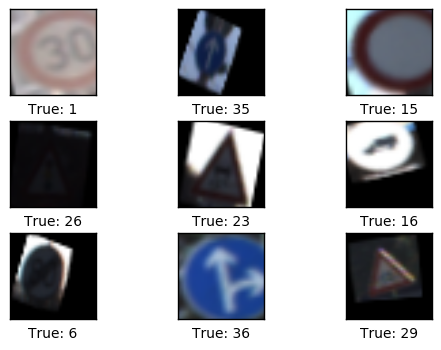

In [6]:
# Visualize the additional augmented data
ids = [0, 7000, 15000, 17000, 20000, 25000, 27000, 30000, 40000]
x_tmp = [x_more[i] for i in ids]
y_tmp = [y_more[i] for i in ids]
plot_images(x_tmp, y_tmp, None)

In [7]:
#
# Additional pre-processing: Normalization
# Normalization of the input data helps with training in the same way that
# a uniform weight distribution helps...i.e, a smoother gradient descent and
# avoidance of suboptimal minima in the gradient landscape. This is because it
# ensure that all images that go through the system have the same weight when
# training the model. The absence of such normalization would achieve a bad training
# outcome as images with generally higher pixel values will influence the gradient
# descent step more than other images.
#
# It is also necessary that normalization should be relative to ALL the images,
# and not performed in isolation for each image. In other words, the new distribution
# of pixel values should have the same mean and the same std deviation across all
# images.
#
# Therefore, I chose to use MIN_MAX normalization, to achieve such a distribution.
# The range selected here has a mean of 0.0 and a variance of 1.0. Centering the mean
# on 0.0 can be intuitively seen to be a more neutral starting point, and again, 
# since it is a fixed value across all images no individual image can influence the
# training more than any other image.
#
# Normalize the input_images (and save originals)
#
x_train_norm = np.zeros_like(x_train, dtype=float32)
x_test_norm = np.zeros_like(x_test, dtype=float32)
for i in range(0, len(x_train)):
    cv2.normalize(x_train[i], x_train_norm[i], 0.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
for i in range(0, len(x_test)):
    cv2.normalize(x_test[i], x_test_norm[i], 0.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

#
# Here I determine exactly how many classes exist, so that a one-hot encoding of expected
# labels can be determined, for the training step.
#
num_classes = len(np.unique(y_train))
y_train_hot = dense_to_one_hot(y_train, num_classes) # One-hot encode all the labels
y_test_hot = dense_to_one_hot(y_test, num_classes) # One-hot encode all the labels

print ("Normalization succeeded")

Normalization succeeded


In [8]:
#
#  Prepare 'Data' objects: These were structures/classes that allowed me to encapsulate
#      all the data related to each 'set' of data (training, test, validation), including:
#          - Post-processed images before training/testing
#          - Pre-processed (raw) images
#          - Labels (a single-valued label)
#          - Hot labels (labels expressed as one-hot-encodings of the class vector)
#          - # of samples in the given set
#          - Batch-size for this set (used to tweak the training/test/validation performance)
#  This sort of encapsulation was necessary because the number of variables to keep track of
#  with each set of data was becoming prone to errors.
#

# Create the data objects that will be used going forward
train = Data(x_train_norm, x_train, y_train, y_train_hot, len(x_train), batch_size=128) # Use the normalized input_images (x_train_norm)
test = Data(x_test_norm, x_test, y_test, y_test_hot, len(x_test), batch_size=256) # Use the normalized input_images (x_test_norm)
meta = Meta(x_test_norm[0].shape, len(x_test[0][0][0]), num_classes)

print("Size of:")
print("- Training-set:\t\t{}".format(train.count))
print("- Test-set:\t\t{}".format(test.count))
print("- Shape:\t\t{}".format(meta.image_shape))
print("- Num channels:\t{}".format(meta.num_channels))
print("- Num classes:\t{}".format(meta.num_classes))


Size of:
- Training-set:		96750
- Test-set:		12630
- Shape:		(32, 32, 3)
- Num channels:	3
- Num classes:	43


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
#
#
# Configuration Parameters:
#
#
params = Params (\
                 num_train_epochs=0,
                 learning_rate=1e-3,
                 dropout=0.5, # this is actually keep_prob
                 validation_set_size=int(0.10 * train.count),
                 validation_frequency=100, # Validation is performed every 'n' batches
                 training_accuracy_threshold=0.95, \
                 do_checkpointing=False)



In [10]:

#################################
#          PIPELINE             #
#################################

# Convolutional layers:
filter_size1 = 5          # Convolution filters are 5 input_images 5 pixels.
num_filters1 = 32         # There are 16 of these filters.

filter_size2 = 5          # Convolution filters are 5 input_images 5 pixels.
num_filters2 = 64         # There are 36 of these filters.

filter_size3 = 5          # Convolution filters are 5 input_images 5 pixels.
num_filters3 = 128         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 1024             # Number of neurons in fully-connected layer.

# Plot some training samples
#plot_images(images=train.pre_images[0:9], actual_labels=train.labels[0:9])

images = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='images')
actual_hot_labels = tf.placeholder(tf.float32, shape=[None, num_classes], name='actual_hot_labels')
actual_labels = tf.argmax(actual_hot_labels, dimension=1, name="actual_labels")
keep_prob = tf.placeholder(tf.float32, name='keep_prob') #dropout (keep probability)

# Network architecture/layers
layer, _ = None, None
layer, _ = layer_conv1, weights_conv1 = new_conv_layer(input=images, num_input_channels=num_channels, filter_size=filter_size1, num_filters=num_filters1, use_pooling=True, name='layer_conv1')
#layer = layer_dropout1 = tf.nn.dropout(layer, keep_prob, name='layer_dropout1')

layer, _ = layer_conv2, weights_conv2 = new_conv_layer(input=layer, num_input_channels=num_filters1, filter_size=filter_size2, num_filters=num_filters2, use_pooling=True, name='layer_conv2')
#layer = layer_dropout2 = tf.nn.dropout(layer, keep_prob, name='layer_dropout2')

layer, _ = layer_conv3, weights_conv3 = new_conv_layer(input=layer, num_input_channels=num_filters2, filter_size=filter_size3, num_filters=num_filters3, use_pooling=True, name='layer_conv3')
#layer = layer_dropout3 = tf.nn.dropout(layer, keep_prob, name='layer_dropout3')

layer, _ = layer_flat1, num_features = flatten_layer(layer, name='layer_flat1')

layer = layer_fc1 = new_fc_layer(input=layer, num_inputs=num_features, num_outputs=fc_size, use_relu=True, name='layer_fc1')
layer = layer_dropout4 = tf.nn.dropout(layer, keep_prob, name='layer_dropout4')

layer = logits = layer_fc2 = new_fc_layer(input=layer, num_inputs=fc_size, num_outputs=num_classes, use_relu=False, name='layer_fc2')
#layer = logits = layer_dropout5 = tf.nn.dropout(layer, keep_prob, name='layer_dropout5')

hot_label_predictor = tf.nn.softmax(logits, name='hot_label_predictor')
label_predictor = tf.argmax(hot_label_predictor, dimension=1, name='label_predictor')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=actual_hot_labels, name='cross_entropy')
cost = tf.reduce_mean(cross_entropy, name='cost')
optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate, name='optimizer').minimize(cost)
#correct_prediction = tf.equal(label_predictor, actual_labels,name='correct_prediction')
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='accuracy')


In [11]:
#
# Finally, we're down to the point when the network is trained
# and the test set is run against it periodically to determine accuracy.
#
print ("Intializing session:")
saver = tf.train.Saver()
session = tf.Session()
if ((not saver is None) and (os.path.isfile(checkpoint_file))):
    print ("\tUsing checkpoint.")
    saver.restore(session, checkpoint_file)
else:
    print ("\tUsing default initialization.")
    session.run(tf.initialize_all_variables())



Intializing session:
	Using checkpoint.


In [28]:
# Now start the training epochs
# If a checkpoint has been saved already (checkpoints/checkpoint.chk) this will load
# and continue training where it last was.
# If the params.num_train_epochs is set to None, it will train indefinitely, until 
# params.training_accuracy_threshold is attained.
# If params.do_checkpointing is set to True, the checkpoint will keep getting updated
# with the latest weights/biases etc. For the time being, it is said to False, to
# retain the original trained settings.
unlimited_epochs = params.num_train_epochs == None
if (unlimited_epochs or params.num_train_epochs > 0):
    keep_going = True
    epoch = 0
    while keep_going:
        if os.path.isfile(abort_file):
            print ("\tAbort file found. Aborting training. [To continue, re-run training.]")
            os.remove(abort_file)
            break
    
        print ("\tTraining epoch: {}".format(epoch+1))
        train = shuffle(train)
        train_epoch(optimizer, label_predictor, train, meta, params, session, images, actual_hot_labels, keep_prob)
    
        if (params.do_checkpointing):
            print ("\t\tSaving checkpoint.")
            saver.save(session, checkpoint_file)
        else:
            print ("\t\tCheckpointing disabled.")
            
        test = shuffle(test)
        correct, accuracy, predictions, gradings = check_accuracy(label_predictor, test, meta, params, session, images, actual_hot_labels, keep_prob)
        print("\t\t\tAccuracy on Test-Set: {0:.1%} ({1} / {2})".format(accuracy, correct, test.count))
            
        if accuracy >= params.training_accuracy_threshold:
            print("\t\t\tAchieved threshold accuracy! Ending training.")
            break
        epoch += 1
        keep_going = unlimited_epochs or epoch < params.num_train_epochs
    
    test = shuffle(test)
correct, accuracy, predictions, gradings = check_accuracy(label_predictor, test, meta, params, session, images, actual_hot_labels, keep_prob)
print("Final accuracy on Test-Set: {0:.1%} ({1} / {2})".format(accuracy, correct, test.count))

print ("\nDONE!")


Final accuracy on Test-Set: 93.1% (11755 / 12630)

DONE!


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

For pre-processing, I have done the following.
- Determine the distribution of data based on classes (print_distribution())
- Equalize the distribution by generating new data for each class. The number of samples generated depends on the gap between the sample count of the class, and the count of the most frequent class. Therefore, at the end, the distribution would be equal across all the classes. (equalize_distribution())
- This augmented data is generated from the existing samples, by performing a shear, angular and translational transformation, as well as resizing. (equalize_distribution())



### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

The following steps are taken for trainign:
- Iteration is done on the basis of _epochs_, which are configured in the _params_ variable.
- For each epoch:
  - Shuffle the entire training data set (including augmented data)
  - Split the training data into a _training_ set and a _validation_ set (typically a 90/10 split), which is configurable in _params_.
      - Perform training of the training set in 'x' batches, which depends on the 'batch_size' defined for that set. For training it is ~128.
      - Every time I train the '100'th batch (of the trainign set above), I measure the accuracy of the network against the validation set with batchsize also ~128.
  - At the end of each epoch, I _checkpoint_ the network weights/biases and other variables to disk.
  - I also check the accuracy of the network on the actual _test_ set, which had been kept aside until now. Ideally, I should remain blind to this training set until the very end of the experiment, but it was too tempting to get at least some idea of the progress of accuracy on both _test_ and _validation_ sets.

There are different behaviors of the training iteration:
- Run for a fixed # of epochs (setting _num_epochs_ in the _params_ object).
- Run for a variable # of epochs, until the accuracy crosses a specified _configurable_ threshold. This is useful when retraining a network that is expected to converge to a high accuracy).
- In either case, an _abort_ file is queried at the start of each epoch. If this file exists, the training is aborted (and the file gets removed so that the next invocation does not block). So, to abort a training run, just invoke _touch abort_ in the folder where this notebook exists, and it will abort the training.

Checkpointing:
- A setting called _params_.do_checkpointing determines wehther the network will perform checkpoints of the session state. This helps to pick up training the network where it was last left off, OR, it could help to run the trained network against real data.
- If a checkpoint is already available, the network will load it without asking. The only controllable behavior is whether it checkpoints new training data back onto the checkpoint (which was discussed in the previous point).


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The final architecture, as you can see from above, consists of:
    - Input layer
    - Conv layer 1 (Filter size = 5 x 5 x 3)
    - Max pooling (3 x 3)
    - Relu
    - Conv layer 2 (Filter size = 5 x 5 x 3)
    - Max pooling (3 x 3)
    - Relu
    - Conv layer 3 (Filter size = 5 x 5 x 3)
    - Max pooling (3 x 3)
    - Relu
    - Flatten Layer 1
    - Fully Connected Layer 1 (1024)
    - Dropout Layer 1
    - Fully Connected Layer 2 (1024)
    - Softmax layer (Hot Label Prediction)
        - Outputs 43 logits
    - Argmax layer (Label prediction)
        - Outputs 1 number (the class number)
    - Cross Entropy
    - Cost Function
    - Adam Optimizer (learning rate = 1e-3)
    

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

**Answer:**

This was the toughest part of the project. 95% of the time for this project was spent running the model and tweaking hyper parameters. Since there are an endless combination of hyper parameters available, this quickly became a non-trivial problem to solve. Gradually, I settled on the following parameters:
- Learning Rate = 1e-3 (this seemed to give me optimal convergence)
- Optimizer = Adam Optimizer
- I also tweaked and played with different network architectures.
    - At this time, I was using 2 CNs + 2 FCs, with 1 Dropout. But this model was not giving me a consistent accuracy on the test data. For training data, it converged to ~99%, but test accuracy remained between 85-96%. This inconsistency prompted me to add another CN to the architecture, and to increase the size of the CNs and the number of filters.
    - The second network architecture gave me much greater stability, but convergence usually ended at a 92% test accuracy, after which point it would grow very incrementally, and I could tell that the network was already overfitting to the training data. On epoch # ~11 or 12, I considered the training complete.
    - The results above were stable, I feel, because of the tremendous amount of training data that I was able to generate. This slowed down the overfitting, and helped the network generalize more to new use cases. In the interest of time, I decided to accept the 92% accuracy, knowing that the next time I have such a project to work on, I will very likely do a better job as I have a better idea of how to choose hyper parameters now.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

Given my lack of experience in this domain, my approach was to learn by trying. I attempted numerous hyperparams and network architecture changes, and along the way I've become quite comfortable with not only tensor flow but python in general.

My initial approach was to find working code for CNNs online, and to refactor it to suit my specific needs. Though this worked for the most part, and was acceptable as a first attempt, I also realized that using this approach was very limiting in the later states of the project because it narrowed me down interms of flexibility, and caused me to waste a lot of time trying to work with what was available, instead of building code that reflected my needs and was flexible enough for my experimental approach. The next time I implement something like this, I will utilize my own style of coding up this solution, and will only rely on online resources for inspiration.

Ultimately, I decided that a consistent model that gave me 92-93% accuracy was better than an inconsistent model that ranged between 85-95% accuracy, and that's what I have submitted with this assignment.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### REDING IMGES>>>>
Loaded 18 samples of real data
Here are some examples


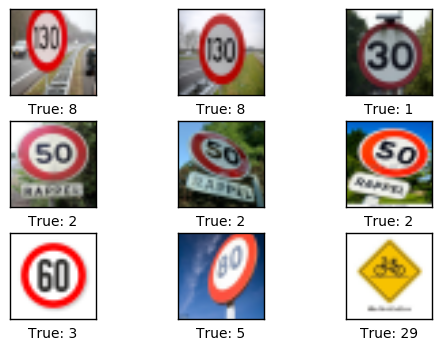

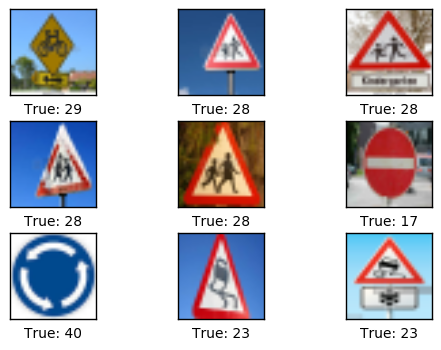

In [23]:
real_dir = "real_data"

# This is a diciontary mapping the file name to the class it belongs to (or the closest known class)
mappings = {"130_km_1.jpg": 8, # Actual class is non-existent in this set, but this is the closest known match
            "130_km_2.jpg": 8, # Same as above
            "30_km_1.jpg": 1,
            "50_km_1.jpg": 2,
            "50_km_2.jpg": 2,
            "50_km_3.jpg": 2,
            "80_km_1.jpg": 5,
            "60_km_1.jpg": 3,
            "slippery_1.jpg": 23,
            "slippery_2.jpg": 23,
            "children_1.jpg": 28,
            "children_2.jpg": 28,
            "children_3.jpg": 28,
            "children_4.jpg": 28,
            "roundabout_1.jpg": 40,
            "bicycle_1.jpg": 29,
            "bicycle_2.jpg": 29,
            "no_entry_1.jpg": 17}

preimages, imgs, labels, labelsonehot, names = read_images(real_dir, mappings, 43)
print ("Loaded {} samples of real data".format(len(preimages)))
data = Data(pre_images = preimages, images=imgs, labels=labels, hot_labels=labelsonehot, count=len(preimages), batch_size=100)
print ("Here are some examples")
plot_images(data.images[0:9], data.labels[0:9])
plot_images(data.images[9:18], data.labels[9:18])
# data = shuffle(data)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
Let's take the real data loaded above, and run them through the model.

First, let's look at some of the images.

Here's 9 images from the set above:

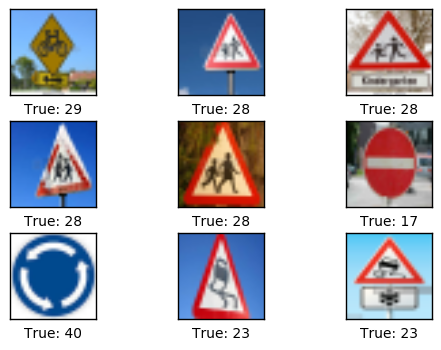

In [24]:
plot_images(data.images[9:18], data.labels[9:18])

**Answer:**

Her are some observations about those 9 images above:
- These images are general brighter than the data on which this model was trained, as can be seen by comparing them to the training image samples illustrated earlier in this notebook.
- 

Real data results:
	#Samples: 18
	Accuracy: 38.9%
Here are some sample errors:


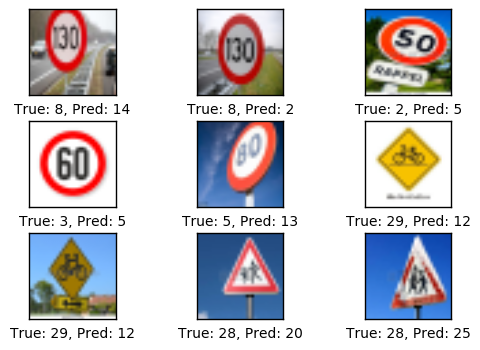

In [26]:
correct, acc, predictions, gradings = check_accuracy(label_predictor, data, meta, params, session, images, actual_hot_labels, keep_prob)
print ("Real data results:")
print ("\t#Samples: {}".format(len(imgs)))
print ("\tAccuracy: {:.1%}".format(acc))
print ("Here are some sample errors:")
plot_example_errors(data, predictions, gradings)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

Though the model is robust enough to 'handle' intake of such imges, with vastly varying perspectives, orientations, rotations etc, the actual categorization can sometimes be incorrect. This is because many of the 'real' images that I collected were either not categorized at all (eg. the images titled '130_km_1' and '130_km_2' do not belong to any known category for the network), or were sufficiently close in appearance to another category (eg. images of the 60kmph sign being mistaken as 80kmph). The accuracy is rather low at the moment, perhaps because I used images that would cause confusion.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**



In [15]:
top_k_layer = tf.nn.top_k(hot_label_predictor, k=3, sorted=True, name='top_k_layer')
data = shuffle(data)
feed_dict_train = {images: imgs, actual_hot_labels: labelsonehot, keep_prob: params.dropout}
(top_k_values, top_k_indices) = session.run(top_k_layer, feed_dict=feed_dict_train)

print ("Here are the closest matches...")
for i in range(len(top_k_values)):
        matches = top_k_indices[i]
        print ("\tImage #: [{}] {} ~~~ {}".format(i, names[i], matches))


Here are the closest matches...
	Image #: [0] 130_km_1.jpg ~~~ [14 12 13]
	Image #: [1] 130_km_2.jpg ~~~ [2 8 9]
	Image #: [2] 30_km_1.jpg ~~~ [ 1  5 31]
	Image #: [3] 50_km_1.jpg ~~~ [1 9 2]
	Image #: [4] 50_km_2.jpg ~~~ [ 2 17 25]
	Image #: [5] 50_km_3.jpg ~~~ [ 5  0 14]
	Image #: [6] 60_km_1.jpg ~~~ [5 3 2]
	Image #: [7] 80_km_1.jpg ~~~ [12 13  5]
	Image #: [8] bicycle_1.jpg ~~~ [12 42 17]
	Image #: [9] bicycle_2.jpg ~~~ [12 42 13]
	Image #: [10] children_1.jpg ~~~ [20 30 25]
	Image #: [11] children_2.jpg ~~~ [28  3 29]
	Image #: [12] children_3.jpg ~~~ [25 38 20]
	Image #: [13] children_4.jpg ~~~ [28  3 20]
	Image #: [14] no_entry_1.jpg ~~~ [17  0  1]
	Image #: [15] roundabout_1.jpg ~~~ [40 34  0]
	Image #: [16] slippery_1.jpg ~~~ [31 25 21]
	Image #: [17] slippery_2.jpg ~~~ [30 23 25]


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


At the moment, the interface is really just a folder where the images need to be dropped,
and a mappings dictionary wherein the label for each image name is provided. The set of 
images and corresponding labels are provided as paired vectors to the network, to determine
its predictions. The interface is therefore very simple, but if Ihad more time I would have
implemented something more generic.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.